In [2]:
# ANI


# import the calculators
from torch import device
from torchani.models import ANI1x, ANI2x, ANI1ccx

ani1x_calc = ANI1x().ase()
ani1ccx_calc = ANI1ccx().ase()
ani2x_calc = ANI2x().ase()

# device type can defined via torch and parsed to the model via .to() method
#device_ = device('cpu')
#model_ = ANI1x(periodic_table_index=True).to(device_).double().ase()


# MACE
from mace.calculators import mace_mp, mace_off

macemp = mace_mp(
    model="medium", 
    dispersion=False, 
    default_dtype="float32", 
    device='cpu',
    )

maceoff = mace_off(
    model="medium", 
    device='cpu',
    default_dtype='float32'
    )

# ORB

from orb_models.forcefield.pretrained import orb_v2, orb_d3_v2
from orb_models.forcefield.calculator import ORBCalculator

orbff_v2 = orb_v2(device='cpu')
orb_calc_v2 = ORBCalculator(orbff_v2, device='cpu')

orbff_d3_v2 = orb_d3_v2(device='cpu')
orb_calc_d3_v2 = ORBCalculator(orbff_d3_v2, device='cpu')


CALC_NAME = 'ALL'

/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")


/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/resources/
/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/torchani/resources/


/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indice

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.
Using MACE-OFF23 MODEL for MACECalculator with /Users/sergiortizropero/.cache/mace/MACE-OFF23_medium.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/Users/sergiortizropero/miniconda3/envs/ASE_all/lib/python3.10/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_p

In [3]:
# define the calculators
calculator_list = [ani1x_calc, ani1ccx_calc, ani2x_calc, macemp, maceoff, orb_calc_v2, orb_calc_d3_v2]
calculator_names = ['ANI-1x', 'ANI-1ccx', 'ANI-2x', 'MACE-MP', 'MACE-OFF', 'ORB-V2', 'ORB-D3-V2']
calculator_colors = ['darkviolet', 'crimson', 'deeppink', 'darkgreen', 'mediumseagreen', 'royalblue', 'darkblue']

color_dict = {
    'ANI-1x': 'darkviolet', 
    'ANI-1ccx': 'crimson', 
    'ANI-2x': 'deeppink', 
    'MACE-MP': 'darkgreen', 
    'MACE-OFF':  'mediumseagreen', 
    'ORB-V2': 'royalblue', 
    'ORB-D3-V2': 'darkblue',
}

In [4]:
# general imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase import Atoms
from ase.visualize import view
from ase.build import molecule
from ase.io import write, read
from ase.io import Trajectory, trajectory
from ase import build
from ase.data.pubchem import pubchem_atoms_search

In [13]:
def evaluate_rotation(molecule, calculator_list, mol_name, calc_name, verbose=False, rot_angle='z', visualize=False, group=[], cosan=False, resolution=None, forces_display=False):

    # create the working directory
    work_dir = os.path.join(os.curdir, 'symmetries',  mol_name, 'rotamers')
    save_dir = os.path.join(os.curdir, 'symmetries',  mol_name)
    if not os.path.isdir(work_dir):
        os.makedirs(work_dir)

    if len(calculator_list) == 1:
        traj_path = os.path.join(save_dir, f'{mol_name}_{calc_name}_rotation.traj')
        traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')

    # fixed resolution
    if resolution is not None:
        delta_angle = resolution
    else: 
        delta_angle = 6.
    points = int(360./delta_angle)
    angles = np.linspace(0., 360., points+1)
    print(f'{mol_name}')
    print(f'analyzing {points} rotationally different structures')
    print(f'using {len(calculator_list)} models')
    print(f'scanning angles:\n{angles}')

    # define the number of conformers to generate
    points = int(360 / resolution)
    #if type(points) != int:
    #    print('THE RESOLUTION IS NOT COMPATIBLE! SHOULD DIVIDE 360.')
    print(f'performing {resolution} degree dihedral scan')
    dihedral_list = np.linspace(0., 360., points+1)

   
    # save the conformers to disk for reproducibility
    print(f'saving {points+1} conformers')

    # save initial structure
    write(os.path.join(work_dir, f'cosan_conf_{0}.xyz'), molecule)

    energies = []
    forces = []
    sucessful_calcs = []

    k = 0
    for calc_ in calculator_list:
        k += 1

        try:

            molecule.calc = calc_
            calc_energy_list = []
            calc_force_list = []
            calc_torque_list = []

            i = 0
            for angle in angles:
                
                i += 1

                
                energy_ = molecule.get_potential_energy()
                force = np.array(molecule.get_forces())
                f_vec = force.sum(axis=0)
                f_scalar = np.sqrt(f_vec.dot(f_vec))

                calc_energy_list.append(energy_)
                calc_force_list.append(f_scalar)
                
                if verbose:
                    print(f'energy ({angle:.0f} deg)\t{energy_}')
                
                if len(calculator_list) == 1:
                    traj.write(molecule)

                if len(group) == 0:
                    molecule.rotate(delta_angle, rot_angle)

                    # save all conformers for gaussian
                    write(os.path.join(work_dir, f'cosan_conf_{i-1}.xyz'), molecule)


                # perform a group rotation
                else:
                    subsys = molecule[group]
                    subsys.rotate(rot_angle, delta_angle, rotate_cell = False)
                    molecule.positions[group] = subsys.positions

                    # save all conformers for gaussian
                    write(os.path.join(work_dir, f'cosan_conf_{i-1}.xyz'), molecule)

            energies.append(calc_energy_list)
            forces.append(calc_force_list)
            sucessful_calcs.append(calculator_names[k-1])

        except: print(f'calculator {calculator_names[k-1]} did not work')

        if visualize:
            if len(calculator_list) == 1:
                traj = trajectory.TrajectoryReader(traj_path)
                view(traj, viewer='ase')

    #print(f'resulting energies:\n{energies}')
    #print(f'resulting forces (total, scalar):\n{force}')






    # convert all rotamers to Gaussian input file format
    target_files = [x for x in os.listdir(work_dir) if x!='.DS_Store']
    print(target_files)

    #os.system(f'ase convert -h')
    #os.system(f'ase info --formats')
    print('converting files to Gaussian input format')

    #os.system(f'ase convert -i xyz -o gaussian-in {os.path.join(work_dir, target_files[0][:-4])}.xyz {os.path.join(work_dir, target_files[0][:-4])}.gjf') 

    for file in target_files:
        #print(f'ase convert -i xyz -o gaussian-in {os.path.join(work_dir, file[:-4])}.xyz {os.path.join(work_dir, file[:-4])}.gjf')
        #print(f'ase convert {os.path.join(work_dir, file[:-4])}.xyz -o {os.path.join(work_dir, file[:-4])}.gjf')
        #os.system(f'ase convert {os.path.join(work_dir, file[:-4])}.xyz -o {os.path.join(work_dir, file[:-4])}.gjf') 
        os.system(f'ase convert -i xyz -o gaussian-in {os.path.join(work_dir, file[:-4])}.xyz {os.path.join(work_dir, file[:-4])}.gjf')







    # plot the energies
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4))
    
    if cosan:
        ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
        ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
        ax_twin = plt.twinx(ax)
        ax_twin.tick_params(bottom=False, top=False, left=False, right=True, direction="in")
        ax_twin.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=True, direction="in")
        
        plots = []
        for k in range(len(sucessful_calcs)):
            idx = np.argmin(energies[k][:])
            min_energy = energies[k][idx]


            if k == 0:
                p = ax.plot(angles, (np.array(energies[k][:])-min_energy), label=r'$\textnormal{' + sucessful_calcs[k] + r'}$', color=color_dict[sucessful_calcs[k]], alpha=1.0, lw=2)
                plots.append(p)
            else:
                p = ax_twin.plot(angles, (np.array(energies[k][:])-min_energy), label=r'$\textnormal{' + sucessful_calcs[k] + r'}$', color=color_dict[sucessful_calcs[k]], alpha=0.6)
                plots.append(p)

            ax.set(xlabel=r'$z\textnormal{-axis rotation}\;(\textnormal{deg}\;^\circ)$', ylabel=r'$\Delta E\quad\textnormal{(eV) (\textbf{MACE})}$')
            ax_twin.set(xlabel=r'$z\textnormal{-axis rotation}\;(\textnormal{deg}\;^\circ)$', ylabel=r'$\Delta E\quad\textnormal{(eV) (\textbf{ORB})}$')

        plots_sum = plots[0]+plots[1]+plots[2]
        labs = [p.get_label() for p in plots_sum]
        ax_twin.legend(plots_sum, labs, loc='best', title=f'{mol_name}', title_fontsize='large', prop={'size': 9})

    else:
        ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
        ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
        
        for k in range(len(sucessful_calcs)):
            idx = np.argmin(energies[k][:])
            min_energy = energies[k][idx]
            ax.plot(angles, (np.array(energies[k][:])-min_energy), label=r'$\textnormal{' + sucessful_calcs[k] + r'}$', color=color_dict[sucessful_calcs[k]], alpha=0.7)

        #'$z\;\textnormal{-axis rotation}\;\textnormal{(deg)}$'
        ax.set(xlabel=r'$z\textnormal{-axis rotation}\;(\textnormal{deg}\;^\circ)$', ylabel=r'$\Delta E\quad\textnormal{(eV)}$')
        # workaround only to avoid displaying very small numbers (truncation errors)
        #ax.set_ylim(-1e-5, 1e-5)
        ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large', prop={'size': 9})
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{mol_name}_{calc_name}_energy_rotation.png'), dpi=400)
    plt.show(fig)

    if forces_display:

        # plot the forces
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4))
        ax.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
        ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

        for k in range(len(sucessful_calcs)):
            idx = np.argmin(forces[k][:])
            min_energy = forces[k][idx]
            ax.plot(angles, (np.array(forces[k][:])-min_energy), label=r'$\textnormal{' + sucessful_calcs[k] + r'}$', color=color_dict[sucessful_calcs[k]], alpha=0.7)

        #'$z\;\textnormal{-axis rotation}\;\textnormal{(deg)}$'
        ax.set(xlabel=r'$z\textnormal{-axis rotation}\;(\textnormal{deg}\;^\circ)$', ylabel=r'$\textnormal{Total forces}\quad\textnormal{(eV/Å)}$')
        # workaround only to avoid displaying very small numbers (truncation errors)
        #ax.set_ylim(-1e-5, 1e-5)
        ax.legend(loc='best', title=f'{mol_name}', title_fontsize='large', prop={'size': 9})
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'{mol_name}_{calc_name}_forces_rotation.png'), dpi=400)
        plt.show(fig)

cosan_scan
analyzing 2 rotationally different structures
using 1 models
scanning angles:
[  0. 180. 360.]
performing 180 degree dihedral scan
saving 3 conformers
['cosan_conf_2.xyz', 'cosan_conf_1.xyz', 'cosan_conf_0.xyz']
converting files to Gaussian input format


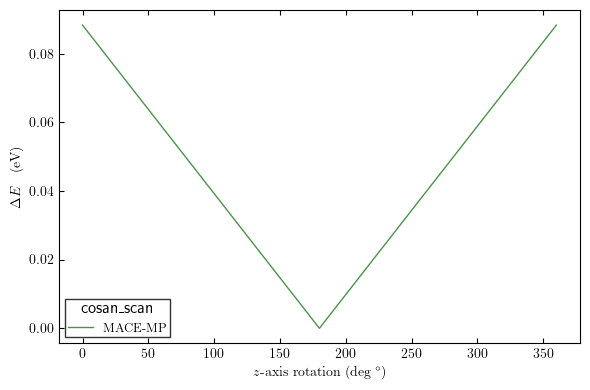

In [14]:
mol_name = 'cosan_scan'
cosan_xyz = '/Users/sergiortizropero/TFG_phys/NNPs_TFG/examples/COSAN/cosan.xyz'
cosan = read(cosan_xyz)

# define the calculators
calculator_list = [macemp, orb_calc_v2, orb_calc_d3_v2]
calculator_list = [macemp]
calculator_names = ['MACE-MP', 'ORB-V2', 'ORB-D3-V2']
calculator_names = ['MACE-MP']

color_dict = {
    'ANI-1x': 'darkviolet', 
    'ANI-1ccx': 'crimson', 
    'ANI-2x': 'deeppink', 
    'MACE-MP': 'darkgreen', 
    'MACE-OFF':  'mediumseagreen', 
    'ORB-V2': 'royalblue', 
    'ORB-D3-V2': 'darkblue',
}

group = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
evaluate_rotation(cosan, calculator_list, calc_name=CALC_NAME, mol_name=mol_name, visualize=False, group=group, cosan=False, resolution=180, forces_display=False)